### Import Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Labeling Dataset based on the Directory Names

In [16]:
datasetDir = 'Dataset'

# get the Subdirectory of the Dataset Folder
for root, folder, files in os.walk(datasetDir):
    if folder != []:
        listDir = folder

classes = []
# retrieve the name and the number of the classification
for i, category in enumerate(listDir):
    # print(category)
    classes.append(category)
    # classes.append({'name' : category,'id' : i + 1, "category" : category})
classes

['Bag',
 'Book',
 'Chair',
 'Cup',
 'Eraser',
 'Fork',
 'Pen',
 'Pencil',
 'Pencil Case',
 'Plate',
 'Soap',
 'Spoon',
 'Table',
 'Toothbrush',
 'Toothpaste']

### Import Dataset

In [17]:
from keras.preprocessing.image import ImageDataGenerator

# Create a datagen that is split the dataset into 80% Train and 20% Test
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    shear_range=20,
    zoom_range=0.5,
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
)

# val_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=90,
#     shear_range=20,
#     zoom_range=0.5,
#     width_shift_range=0.5,
#     height_shift_range=0.5,
#     horizontal_flip=True,
#     validation_split=0.2,
# )

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Training Set
training_set = datagen.flow_from_directory(
    datasetDir,
    target_size=(299,299),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset="training",
    batch_size=128
)

# Validation Set
validation_set = datagen.flow_from_directory(
    datasetDir,
    target_size=(299,299),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset="validation",
    batch_size=128
)

test_set = test_datagen.flow_from_directory(
    'Test Set',
    target_size=(299,299),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=128
)

Found 2615 images belonging to 15 classes.
Found 647 images belonging to 15 classes.
Found 291 images belonging to 15 classes.


<h3>Load Model Inception V3</h3>

In [18]:
base_model = InceptionV3(weights='imagenet' , include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False
base_model.trainable

False

In [19]:
model = tf.keras.models.Sequential([
    base_model,
    # tf.keras.layers.AveragePooling2D(pool_size=(8, 8)),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(classes) , activation='softmax')
])

In [20]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x0000022EA5C503D0> False
<keras.layers.core.flatten.Flatten object at 0x0000022DF94038E0> True
<keras.layers.core.dense.Dense object at 0x0000022EA5C4B610> True


In [21]:
from datetime import datetime

now = datetime.now()
date_string = now.strftime('%d-%m-%Y-%H-%M-%S')
start = date_string

### Callbacks

In [22]:
model_type = 'InceptionV3-Adam-0.0001'
ckpt_path = f'Checkpoints/InceptionV3/{model_type}/{model_type}-checkpoints' + date_string + '_{accuracy:.3f}-training_log.hdf5'
log_path = f'Logs/{model_type}.csv'

In [23]:
record = open(f'Records/{model_type} record.txt' , 'a')
record.write(f'{model_type} \n')
record.write(f'Start : {start} \n')
record.close()

In [24]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor = 'val_accuracy',
        mode = 'max',
        save_freq='epoch',
        save_best_only= True,
        verbose= 1
    ),
    tf.keras.callbacks.CSVLogger(
        log_path,
        separator=',',
        append=True
    )
]

In [25]:
# model.load_weights(f'Checkpoints/InceptionV3/{model_type}/InceptionV3-Adam-0.0001-128Batch-checkpoints22-06-2022-23-15-29_0.688.hdf5')

In [26]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [27]:
model.fit(
    training_set,
    epochs = 200,
    verbose = 1,
    # initial_epoch=114,
    validation_data = validation_set,
    callbacks = callbacks,
    batch_size = 32,
    shuffle = True
)

Epoch 1/200
21/21 [==============================] - ETA: 0s - loss: 2.3850 - accuracy: 0.3350
Epoch 1: val_accuracy improved from -inf to 0.51314, saving model to Checkpoints/InceptionV3/InceptionV3-Adam-0.0001\InceptionV3-Adam-0.0001-checkpoints26-06-2022-12-41-07_0.335.hdf5
21/21 [==============================] - 143s 7s/step - loss: 2.3850 - accuracy: 0.3350 - val_loss: 1.4254 - val_accuracy: 0.5131
Epoch 2/200
21/21 [==============================] - ETA: 0s - loss: 1.3658 - accuracy: 0.5679
Epoch 2: val_accuracy improved from 0.51314 to 0.58578, saving model to Checkpoints/InceptionV3/InceptionV3-Adam-0.0001\InceptionV3-Adam-0.0001-checkpoints26-06-2022-12-41-07_0.568.hdf5
21/21 [==============================] - 126s 6s/step - loss: 1.3658 - accuracy: 0.5679 - val_loss: 1.3529 - val_accuracy: 0.5858
Epoch 3/200
21/21 [==============================] - ETA: 0s - loss: 1.1645 - accuracy: 0.6195
Epoch 3: val_accuracy improved from 0.58578 to 0.62442, saving model to Checkpoints/In

In [ ]:
model.evaluate(test_set, verbose=1)

3/3 [==============================] - 12s 3s/step - loss: 0.6200 - accuracy: 0.8316


[0.6199562549591064, 0.831615149974823]

In [ ]:
model.save(f'Model/{model_type}.h5')

In [ ]:
now = datetime.now()
date_string = now.strftime('%d-%m-%Y-%H-%M-%S')
end = date_string

In [ ]:
record = open(f'Records/{model_type} record.txt' , 'a')
record.write(f"End : {end}" )
record.close()

### Visualize Accuracy and Loss

In [ ]:
import pandas as pd
csv = pd.read_csv(log_path)

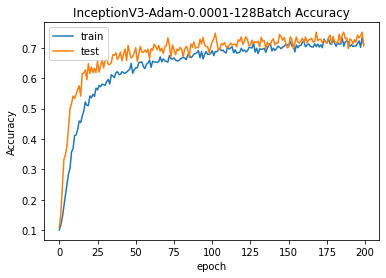

In [ ]:
# summarize history for Accuracy
plt.plot(csv['accuracy'])
plt.plot(csv['val_accuracy'])
plt.title(f'{model_type} Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

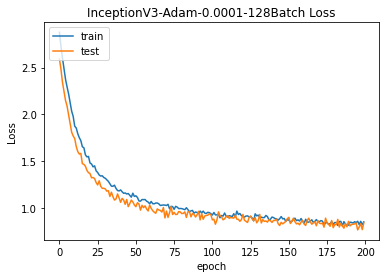

In [ ]:
# summarize history for accuracy
plt.plot(csv['loss'])
plt.plot(csv['val_loss'])
plt.title(f'{model_type} Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()